In [1]:
import pandas as pd
import numpy as np
from glob import glob
import re
import nltk
import plotly_express as px
from nltk.corpus import stopwords
from nltk import pos_tag
import os
from textparser import TextParser
import random
from numpy.linalg import norm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import PCA
from scipy.linalg import norm, eigh

In [2]:
OHCO = ['movie_id','scene_id', 'sent_num', 'token_num']
SENTS = OHCO[:3]
SCENES = OHCO[:2]
MOVIES = OHCO[:1]

In [3]:
LIB = pd.read_csv('/Users/theothormann/Desktop/Data Science/Spring/DS5001/FinalData/LIB.csv', index_col='movie_id')
CORPUS = pd.read_csv('/Users/theothormann/Desktop/Data Science/Spring/DS5001/FinalData/CORPUS.csv').set_index(OHCO)
VOCAB = pd.read_csv('/Users/theothormann/Desktop/Data Science/Spring/DS5001/FinalData/VOCAB.csv', index_col = 'term_str')

In [4]:
pd.set_option('max_colwidth', 115)

## Generate reduced `TFIDF` table

We reduce the feature space of the the TFIDF table by selecting the top 1000 significant nouns, verbs, and adjectives.

Note that the `TFIDF` table is an extension of an implied `DOC` table, where each doc is a chapter in this case.

### BOW Function

In [5]:
def create_bag(corpus, bag):
    BOW = corpus.groupby(bag+['term_str']).term_str.count().to_frame('n')
    return BOW

In [6]:
BOW = create_bag(corpus = CORPUS, bag = ['movie_id', 'scene_id'])

In [7]:
BOW

n
movie_id scene_id term_str    
0        1        a         10
                  airlock    1
                  alive      1
                  and        3
                  angle      1
...                         ..
36       111      open       1
                  out        1
                  quiet      1
                  the        3
                  through    1

[481251 rows x 1 columns]

### TFIDF Function

In [8]:
def get_tfidf(BOW, tf_method='max', df_method='standard', item_type='term_str'):
            
    DTCM = BOW.n.unstack() # Create Doc-Term Count Matrix
    
    if tf_method == 'sum':
        TF = (DTCM.T / DTCM.T.sum()).T
    elif tf_method == 'max':
        TF = (DTCM.T / DTCM.T.max()).T
    elif tf_method == 'log':
        TF = (np.log2(DTCM.T + 1)).T
    elif tf_method == 'raw':
        TF = DTCM
    elif tf_method == 'bool':
        TF = DTCM.astype('bool').astype('int')
    else:
        raise ValueError(f"TF method {tf_method} not found.")

    DF = DTCM.count() # Assumes NULLs 
    N_docs = len(DTCM)
    
    if df_method == 'standard':
        IDF = np.log10(N_docs/DF) # This what the students were asked to use
    elif df_method == 'textbook':
        IDF = np.log10(N_docs/(DF + 1))
    elif df_method == 'sklearn':
        IDF = np.log10(N_docs/DF) + 1
    elif df_method == 'sklearn_smooth':
        IDF = np.log10((N_docs + 1)/(DF + 1)) + 1
    else:
        raise ValueError(f"DF method {df_method} not found.")
    
    TFIDF = TF * IDF
    
    DFIDF = DF * IDF
    
    TFIDF = TFIDF.fillna(0)

    return TFIDF, DFIDF

In [9]:
TFIDF, DFIDF = get_tfidf(BOW, 'max')

In [10]:
VSHORT = VOCAB[VOCAB.max_pos.isin(['NN', 'VB', 'JJ'])].sort_values('dfidf', ascending=False).head(1000)
TFIDF = TFIDF[VSHORT.index]

In [11]:
TFIDF

term_str                 be      door       see       get      face      here  \
movie_id scene_id                                                               
0        1         0.046383  0.093601  0.000000  0.000000  0.056424  0.000000   
         2         0.000000  0.019855  0.020023  0.000000  0.023937  0.024197   
         3         0.173165  0.000000  0.044052  0.049144  0.105325  0.000000   
         4         0.129873  0.000000  0.000000  0.147432  0.000000  0.000000   
         5         0.099903  0.000000  0.025414  0.028352  0.030382  0.061424   
...                     ...       ...       ...       ...       ...       ...   
36       107       0.046383  0.000000  0.000000  0.052654  0.000000  0.000000   
         108       0.000000  0.218402  0.000000  0.000000  0.000000  0.000000   
         109       0.000000  0.163801  0.000000  0.122860  0.000000  0.000000   
         110       0.015838  0.047942  0.000000  0.053939  0.038533  0.000000   
         111       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

term_str               look    right       go      hand  ...  upward  sword  \
movie_id scene_id                                        ...                  
0        1         0.000000  0.00000  0.00000  0.059539  ...     0.0    0.0   
         2         0.000000  0.07312  0.00000  0.025259  ...     0.0    0.0   
         3         0.000000  0.00000  0.00000  0.055570  ...     0.0    0.0   
         4         0.160474  0.00000  0.00000  0.000000  ...     0.0    0.0   
         5         0.092581  0.00000  0.00000  0.000000  ...     0.0    0.0   
...                     ...      ...      ...       ...  ...     ...    ...   
36       107       0.000000  0.00000  0.00000  0.000000  ...     0.0    0.0   
         108       0.000000  0.00000  0.00000  0.000000  ...     0.0    0.0   
         109       0.000000  0.00000  0.00000  0.138925  ...     0.0    0.0   
         110       0.000000  0.00000  0.01987  0.020330  ...     0.0    0.0   
         111       0.000000  0.00000  0.00000  0.000000  ...     0.0    0.0   

term_str           odd  wine  trunk  press  camp  joke  uniform  cargo  
movie_id scene_id                                                       
0        1         0.0   0.0    0.0    0.0   0.0   0.0      0.0    0.0  
         2         0.0   0.0    0.0    0.0   0.0   0.0      0.0    0.0  
         3         0.0   0.0    0.0    0.0   0.0   0.0      0.0    0.0  
         4         0.0   0.0    0.0    0.0   0.0   0.0      0.0    0.0  
         5         0.0   0.0    0.0    0.0   0.0   0.0      0.0    0.0  
...                ...   ...    ...    ...   ...   ...      ...    ...  
36       107       0.0   0.0    0.0    0.0   0.0   0.0      0.0    0.0  
         108       0.0   0.0    0.0    0.0   0.0   0.0      0.0    0.0  
         109       0.0   0.0    0.0    0.0   0.0   0.0      0.0    0.0  
         110       0.0   0.0    0.0    0.0   0.0   0.0      0.0    0.0  
         111       0.0   0.0    0.0    0.0   0.0   0.0      0.0    0.0  

[5678 rows x 1000 columns]

# Create DOC table

In [12]:
DOC = pd.DataFrame(index=TFIDF.index)
DOC = DOC.join(LIB)
DOC['title'] = DOC.movie_title.astype(str) + ', ' + DOC.year.astype(str)
DOC['year'] = DOC.year.astype(str)
DOC['decade'] = DOC.decade.astype(str)

In [13]:
DOC.to_csv('/Users/theothormann/Desktop/Data Science/Spring/DS5001/FinalData/DOC.csv')

# Begin PCA Process

## Normalize doc vector lengths

We use L2 normalization, which scales documents by their pythagorean (Euclidean) length.

In [14]:
# TFIDF_L2 = (TFIDF.T / np.sqrt(np.square(TFIDF).sum(axis=1))).T
TFIDF_L2 = (TFIDF.T / norm(TFIDF, 2, axis=1)).T

## Normalize term vector variance

We do **not** normalize variance, which we would normally do, such as with data containing divergent units of measure. \
This is because to do so would exaggerate the importance of rare words (see Ng, 2008: 6m40s–8m00s).

## Center the term vectors

We can take the column-wise means (the means for the _term_ vectors), but this alters the cosine angles between terms.

In [15]:
TFIDF_L2 = TFIDF_L2 - TFIDF_L2.mean()

## Compute Covariance Matrix

$n = |X| = |Y|$

$Cov(X,Y) = \dfrac{\sum_{i=1}^{n} (x_i - \mu_X) (y_i - \mu_Y)}{n - 1} = \dfrac{XY}{n-1}$

We could we use the built in Pandas method here, but compute it ourselves.

In [16]:
COV = TFIDF_L2.cov() # This also centers the vectors
#COV = TFIDF_L2.T.dot(TFIDF_L2) / (TFIDF_L2.shape[0] - 1)

In [17]:
COV.head()

term_str        be      door       see       get      face      here  \
term_str                                                               
be        0.002782  0.000012  0.000157  0.000278  0.000042  0.000361   
door      0.000012  0.006585 -0.000163  0.000084 -0.000037 -0.000004   
see       0.000157 -0.000163  0.003876  0.000085  0.000155  0.000116   
get       0.000278  0.000084  0.000085  0.002696  0.000038  0.000369   
face      0.000042 -0.000037  0.000155  0.000038  0.003267 -0.000013   

term_str      look     right        go      hand  ...    upward     sword  \
term_str                                          ...                       
be        0.000197  0.000384  0.000225  0.000001  ... -0.000019 -0.000007   
door     -0.000043  0.000004 -0.000009  0.000039  ... -0.000016  0.000002   
see       0.000168  0.000204  0.000061  0.000079  ... -0.000008 -0.000012   
get       0.000165  0.000220  0.000226 -0.000005  ... -0.000012  0.000020   
face      0.000158  0.000044  0.000014  0.000240  ...  0.000009  0.000011   

term_str           odd          wine         trunk     press      camp  \
term_str                                                                 
be       -3.454588e-06  2.801557e-05  1.933710e-06  0.000014  0.000029   
door     -2.591054e-05 -6.404599e-06  3.248900e-05  0.000031 -0.000034   
see       3.894307e-06  1.196975e-05  1.124473e-05  0.000010 -0.000011   
get      -4.997922e-06 -2.509816e-07 -2.031531e-07  0.000008 -0.000003   
face     -5.837674e-07  5.570691e-06 -1.167373e-05  0.000015 -0.000011   

term_str      joke   uniform     cargo  
term_str                                
be        0.000038  0.000004 -0.000036  
door     -0.000011  0.000006 -0.000040  
see       0.000007  0.000002  0.000024  
get       0.000001  0.000016  0.000023  
face      0.000011  0.000025 -0.000027  

[5 rows x 1000 columns]

## Decompose the Matrix

There a at least three options to choose from. We go with SciPy's Hermitian Eigendecomposition \
method `eigh()`, since our covarience matrix is symmetric.

In [18]:
from scipy.linalg import eigh

In [19]:
eig_vals, eig_vecs = eigh(COV)

## Convert eigen data to dataframes

In [20]:
EIG_VEC = pd.DataFrame(eig_vecs, index=COV.index, columns=COV.index)
EIG_VAL = pd.DataFrame(eig_vals, index=COV.index, columns=['eig_val'])
EIG_VAL.index.name = 'term_str'

In [21]:
colors = "YlGnBu"

In [22]:
EIG_VEC.iloc[:10, :10].style.background_gradient(cmap=colors)

## Explore Term Pairs

In [23]:
EIG_VEC_PAIRS = EIG_VEC.stack().sort_values(ascending=False).to_frame('covariance')
EIG_VEC_PAIRS.index.names = ['term1', 'term2']

In [24]:
# EIG_VEC_PAIRS['label'] = EIG_VEC_PAIRS.apply(lambda x: '-'.join(x.name), axis=1)

In [25]:
EIG_VEC_PAIRS.head(20)

covariance
term1    term2               
phone    camp        0.819350
type     door        0.746687
door     uniform     0.725955
car      cargo       0.601981
yours    face        0.555172
window   trunk       0.548455
radio    wine        0.523296
see      weather     0.512659
window   wine        0.504564
truck    handsome    0.498936
question get         0.488670
bear     here        0.486887
bed      sigh        0.476373
road     upward      0.471889
however  again       0.470259
question here        0.451747
vo       wine        0.450968
again    soul        0.444094
         date        0.443833
stop     pitch       0.442051

In [26]:
# px.scatter(EIG_VEC_PAIRS.sample(10000).sort_values('covariance'), y='label', x='covariance', height=1000)

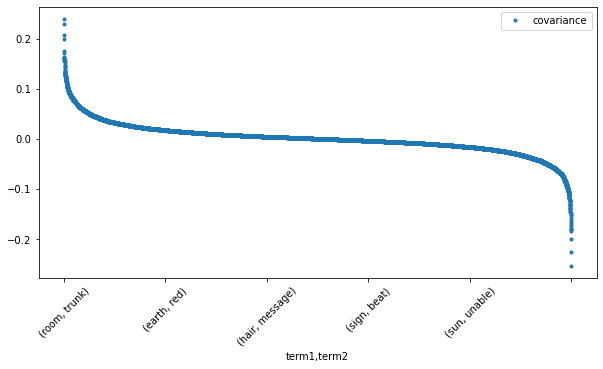

In [27]:
EIG_VEC_PAIRS.sample(10000).sort_values('covariance', ascending=False).plot(rot=45, style='.', figsize=(10,5));

## Select Principal Components

Next, we associate each eigenvalue with its corresponding *column* in the eigenvalue matrix. \
This is why we transpose the `EIG_VEC` dataframe.

## Combine eigenvalues and eignvectors

In [28]:
EIG_PAIRS = EIG_VAL.join(EIG_VEC.T)

In [29]:
EIG_PAIRS.sort_values('eig_val', ascending=False).head(10)

eig_val        be      door       see       get      face  \
term_str                                                               
cargo     0.008870 -0.162226 -0.117074 -0.059367 -0.088992 -0.070978   
uniform   0.008555 -0.094481  0.725955 -0.074824 -0.056450 -0.025526   
joke      0.008027 -0.145830 -0.266064 -0.110733 -0.148210 -0.055322   
camp      0.007079 -0.001227 -0.025785 -0.037870 -0.011445 -0.070541   
press     0.006611 -0.094362  0.102465 -0.076956 -0.058829 -0.047286   
trunk     0.005375 -0.126107 -0.314979  0.187411 -0.074378  0.127326   
wine      0.005122  0.053931  0.037053  0.099768  0.040042 -0.127174   
odd       0.005003  0.026181 -0.112282 -0.173742 -0.054346 -0.067691   
sword     0.004806 -0.017475  0.000007 -0.025480 -0.003449  0.122353   
upward    0.004614 -0.092703  0.005812  0.201744 -0.118386  0.187454   

              here      look     right        go  ...    upward     sword  \
term_str                                          ...                       
cargo    -0.118884 -0.094144 -0.103610 -0.100026  ...  0.000694 -0.000679   
uniform  -0.055824 -0.064249 -0.062779 -0.059514  ... -0.001848  0.001297   
joke     -0.103004 -0.095193 -0.104901 -0.097926  ...  0.006164 -0.013072   
camp     -0.012490 -0.040167 -0.021462 -0.029141  ... -0.007568 -0.007948   
press    -0.087439 -0.059462 -0.056541 -0.053888  ...  0.003658 -0.003888   
trunk    -0.084331 -0.041290 -0.082772 -0.055132  ...  0.000470  0.020875   
wine      0.013924  0.002453 -0.028927  0.002505  ... -0.006158 -0.011698   
odd      -0.004096 -0.053457 -0.060940  0.023575  ... -0.007767  0.007660   
sword    -0.066319 -0.035661  0.040042 -0.052325  ...  0.008403  0.014029   
upward   -0.072165 -0.002823 -0.096007 -0.112519  ... -0.001857  0.004742   

               odd      wine     trunk     press      camp      joke  \
term_str                                                               
cargo    -0.002175 -0.011399  0.015204 -0.006034 -0.005307 -0.005266   
uniform  -0.004401 -0.001304  0.000648 -0.000459 -0.006004 -0.006567   
joke     -0.001380 -0.003366 -0.024387 -0.006831  0.002326 -0.006098   
camp     -0.003061 -0.000877 -0.004877 -0.000933 -0.007250 -0.001107   
press    -0.001351 -0.004288  0.002304 -0.002421 -0.000119 -0.003893   
trunk     0.002809  0.006998  0.002548 -0.001127 -0.002015 -0.006513   
wine     -0.001569 -0.002698  0.002916  0.008992 -0.004559  0.002376   
odd       0.000080  0.001886 -0.000286 -0.002466  0.003281 -0.000653   
sword    -0.000981 -0.000448  0.011874 -0.002056  0.005641  0.001470   
upward    0.005041  0.000787 -0.000797  0.003662 -0.002544 -0.002386   

           uniform     cargo  
term_str                      
cargo    -0.004349  0.003391  
uniform  -0.001065 -0.006377  
joke     -0.007903  0.014340  
camp     -0.000173 -0.010191  
press    -0.000981  0.009387  
trunk     0.004619 -0.013666  
wine      0.009427 -0.002407  
odd      -0.002145 -0.004122  
sword     0.004515  0.008079  
upward    0.006550 -0.013102  

[10 rows x 1001 columns]

Next, we sort in descending order and pick the top K (=10).

## Compute and Show Explained Variance

We might have usd this value to sort our components.

In [30]:
EIG_PAIRS['exp_var'] = np.round((EIG_PAIRS.eig_val / EIG_PAIRS.eig_val.sum()) * 100, 2)

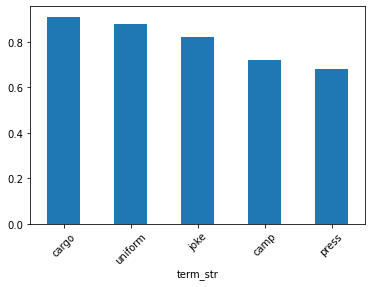

In [31]:
EIG_PAIRS.exp_var.sort_values(ascending=False).head().plot.bar(rot=45);

## Pick Top K (10) Components

We pick these based on explained variance.

In [32]:
COMPS = EIG_PAIRS.sort_values('exp_var', ascending=False).head(10).reset_index(drop=True)
COMPS.index.name = 'comp_id'
COMPS.index = ["PC{}".format(i) for i in COMPS.index.tolist()]
COMPS.index.name = 'pc_id'

In [33]:
COMPS

eig_val        be      door       see       get      face      here  \
pc_id                                                                         
PC0    0.008870 -0.162226 -0.117074 -0.059367 -0.088992 -0.070978 -0.118884   
PC1    0.008555 -0.094481  0.725955 -0.074824 -0.056450 -0.025526 -0.055824   
PC2    0.008027 -0.145830 -0.266064 -0.110733 -0.148210 -0.055322 -0.103004   
PC3    0.007079 -0.001227 -0.025785 -0.037870 -0.011445 -0.070541 -0.012490   
PC4    0.006611 -0.094362  0.102465 -0.076956 -0.058829 -0.047286 -0.087439   
PC5    0.005375 -0.126107 -0.314979  0.187411 -0.074378  0.127326 -0.084331   
PC6    0.005122  0.053931  0.037053  0.099768  0.040042 -0.127174  0.013924   
PC7    0.005003  0.026181 -0.112282 -0.173742 -0.054346 -0.067691 -0.004096   
PC8    0.004806 -0.017475  0.000007 -0.025480 -0.003449  0.122353 -0.066319   
PC9    0.004614 -0.092703  0.005812  0.201744 -0.118386  0.187454 -0.072165   

           look     right        go  ...     sword       odd      wine  \
pc_id                                ...                                 
PC0   -0.094144 -0.103610 -0.100026  ... -0.000679 -0.002175 -0.011399   
PC1   -0.064249 -0.062779 -0.059514  ...  0.001297 -0.004401 -0.001304   
PC2   -0.095193 -0.104901 -0.097926  ... -0.013072 -0.001380 -0.003366   
PC3   -0.040167 -0.021462 -0.029141  ... -0.007948 -0.003061 -0.000877   
PC4   -0.059462 -0.056541 -0.053888  ... -0.003888 -0.001351 -0.004288   
PC5   -0.041290 -0.082772 -0.055132  ...  0.020875  0.002809  0.006998   
PC6    0.002453 -0.028927  0.002505  ... -0.011698 -0.001569 -0.002698   
PC7   -0.053457 -0.060940  0.023575  ...  0.007660  0.000080  0.001886   
PC8   -0.035661  0.040042 -0.052325  ...  0.014029 -0.000981 -0.000448   
PC9   -0.002823 -0.096007 -0.112519  ...  0.004742  0.005041  0.000787   

          trunk     press      camp      joke   uniform     cargo  exp_var  
pc_id                                                                       
PC0    0.015204 -0.006034 -0.005307 -0.005266 -0.004349  0.003391     0.91  
PC1    0.000648 -0.000459 -0.006004 -0.006567 -0.001065 -0.006377     0.88  
PC2   -0.024387 -0.006831  0.002326 -0.006098 -0.007903  0.014340     0.82  
PC3   -0.004877 -0.000933 -0.007250 -0.001107 -0.000173 -0.010191     0.72  
PC4    0.002304 -0.002421 -0.000119 -0.003893 -0.000981  0.009387     0.68  
PC5    0.002548 -0.001127 -0.002015 -0.006513  0.004619 -0.013666     0.55  
PC6    0.002916  0.008992 -0.004559  0.002376  0.009427 -0.002407     0.52  
PC7   -0.000286 -0.002466  0.003281 -0.000653 -0.002145 -0.004122     0.51  
PC8    0.011874 -0.002056  0.005641  0.001470  0.004515  0.008079     0.49  
PC9   -0.000797  0.003662 -0.002544 -0.002386  0.006550 -0.013102     0.47  

[10 rows x 1002 columns]

In [34]:
COMPS.to_csv('/Users/theothormann/Desktop/Data Science/Spring/DS5001/FinalData/COMPS.csv')

In [35]:
# COMPS.iloc[:,1:-1].T.sort_values('PC1', ascending=False).head(10).index

## See Projected Components onto Vocabulary (Loadings)

Loadings sow the contribution of each term to the component. \
We'll just look at the topi 10 words for the first two components in the Book version.

In [36]:
LOADINGS = COMPS[COV.index].T
LOADINGS.index.name = 'term_str'

In [37]:
LOADINGS.to_csv('/Users/theothormann/Desktop/Data Science/Spring/DS5001/FinalData/LOADINGS.csv')

In [38]:
LOADINGS.head(10).style.background_gradient(cmap=colors)

In [39]:
top_terms = []
for i in range(10):
    for j in [0, 1]:
        comp_str = ' '.join(LOADINGS.sort_values(f'PC{i}', ascending=bool(j)).head(10).index.to_list())
        top_terms.append((f"PC{i}", j, comp_str))
COMP_GLOSS = pd.DataFrame(top_terms).set_index([0,1]).unstack()
COMP_GLOSS.index.name = 'comp_id'
COMP_GLOSS.columns = COMP_GLOSS.columns.droplevel(0) 
COMP_GLOSS = COMP_GLOSS.rename(columns={0:'pos', 1:'neg'})

In [40]:
COMP_GLOSS

1                                                                    pos  \
comp_id                                                                    
PC0          car camera road police truck driveway street side snow sign   
PC1      door open room camera hall bedroom window kitchen hallway front   
PC2             camera water ship deck bg snow light cable hull corridor   
PC3           phone camera ear os vo call number radio telephone ringing   
PC4                  phone door ear vo ship light house hall radio water   
PC5               window bed room see face light bedroom house hand wall   
PC6                   radio window vo house see street town be snow open   
PC7               bed room radio car vo light beat living bedroom asleep   
PC8                   radio water hand car vo head ship again light body   
PC9                      road truck radio see side face hand vo room man   

1                                                              neg  
comp_id                                                             
PC0                 room be beat phone here door bed right go look  
PC1               be car phone see little vo radio road look right  
PC2              car door get be front beat police house see right  
PC3         face water body light ship way head ground little stop  
PC4                camera table bg be here hand see beat snow head  
PC5               door radio be ship vo here right get again truck  
PC6            phone hand face car room water light wall body head  
PC7            window see phone door man truck hand head open side  
PC8      bed road truck house little home front street asleep here  
PC9                 window clear car get go ship right be bed here

In [41]:
# COMPS.join(COMP_GLOSS)

## Project Docs onto Components

We get the dot product of the DTM matrix and the new component matrix, which we will call DCM -- for document-component matrix. \
This has the effect of replacing the features of the DTM with the features of the transposed component matrix.

In [42]:
# We use the index to get only PC features, so matrices align
DCM = TFIDF_L2.dot(COMPS[COV.index].T) 

In [43]:
DCM

pc_id                   PC0       PC1       PC2       PC3       PC4       PC5  \
movie_id scene_id                                                               
0        1        -0.004558  0.087707  0.050492 -0.060406  0.052629  0.016199   
         2        -0.131669 -0.015441 -0.049752 -0.058117 -0.038607  0.094707   
         3        -0.093943 -0.094802 -0.060374 -0.024196 -0.073672 -0.015269   
         4        -0.050936 -0.054575  0.000322 -0.003783 -0.029127 -0.075716   
         5        -0.118532 -0.111501 -0.035771 -0.047606 -0.066603 -0.040602   
...                     ...       ...       ...       ...       ...       ...   
36       107      -0.102790 -0.068567 -0.029836  0.275905  0.091809 -0.055527   
         108      -0.038774  0.356002 -0.021972  0.013691  0.103871 -0.041211   
         109      -0.131824  0.279999 -0.071456 -0.006069  0.025049  0.086520   
         110      -0.174761  0.183127 -0.058220  0.016288  0.031547  0.233310   
         111       0.019449  0.122705 -0.015057 -0.004168  0.037706  0.003119   

pc_id                   PC6       PC7       PC8       PC9  
movie_id scene_id                                          
0        1        -0.071773  0.050313  0.060869  0.026770  
         2        -0.052374  0.090831  0.005104  0.018841  
         3        -0.014859 -0.028241 -0.020163 -0.003438  
         4         0.016413  0.013305 -0.043647 -0.073133  
         5        -0.006348 -0.014375  0.037424 -0.023331  
...                     ...       ...       ...       ...  
36       107      -0.079620 -0.045153  0.054346 -0.043349  
         108      -0.000023  0.084908 -0.071000 -0.024367  
         109      -0.061604  0.160414 -0.033866  0.030765  
         110      -0.106201  0.270916 -0.018461  0.055586  
         111       0.021084  0.016188 -0.035183  0.008663  

[5678 rows x 10 columns]

In [44]:
DOC

movie_title  \
movie_id scene_id                       
0        1                     aliens   
         2                     aliens   
         3                     aliens   
         4                     aliens   
         5                     aliens   
...                               ...   
36       107       whenastrangercalls   
         108       whenastrangercalls   
         109       whenastrangercalls   
         110       whenastrangercalls   
         111       whenastrangercalls   

                                                                                                                     source_file_path  \
movie_id scene_id                                                                                                                       
0        1             /Users/theothormann/Desktop/Data Science/Spring/DS5001/PossibleCorpus/imsdb_raw_nov_2015/HorrorSeen/aliens.txt   
         2             /Users/theothormann/Desktop/Data Science/Spring/DS5001/PossibleCorpus/imsdb_raw_nov_2015/HorrorSeen/aliens.txt   
         3             /Users/theothormann/Desktop/Data Science/Spring/DS5001/PossibleCorpus/imsdb_raw_nov_2015/HorrorSeen/aliens.txt   
         4             /Users/theothormann/Desktop/Data Science/Spring/DS5001/PossibleCorpus/imsdb_raw_nov_2015/HorrorSeen/aliens.txt   
         5             /Users/theothormann/Desktop/Data Science/Spring/DS5001/PossibleCorpus/imsdb_raw_nov_2015/HorrorSeen/aliens.txt   
...                                                                                                                               ...   
36       107       /Users/theothormann/Desktop/Data Science/Spring/DS5001/PossibleCorpus/imsdb_raw_nov_2015/HorrorSeen/whenastrang...   
         108       /Users/theothormann/Desktop/Data Science/Spring/DS5001/PossibleCorpus/imsdb_raw_nov_2015/HorrorSeen/whenastrang...   
         109       /Users/theothormann/Desktop/Data Science/Spring/DS5001/PossibleCorpus/imsdb_raw_nov_2015/HorrorSeen/whenastrang...   
         110       /Users/theothormann/Desktop/Data Science/Spring/DS5001/PossibleCorpus/imsdb_raw_nov_2015/HorrorSeen/whenastrang...   
         111       /Users/theothormann/Desktop/Data Science/Spring/DS5001/PossibleCorpus/imsdb_raw_nov_2015/HorrorSeen/whenastrang...   

                   year decade  movie_len  n_scenes                     title  
movie_id scene_id                                                              
0        1         1985   1980      27022       189              aliens, 1985  
         2         1985   1980      27022       189              aliens, 1985  
         3         1985   1980      27022       189              aliens, 1985  
         4         1985   1980      27022       189              aliens, 1985  
         5         1985   1980      27022       189              aliens, 1985  
...                 ...    ...        ...       ...                       ...  
36       107       2006   2000      19009       111  whenastrangercalls, 2006  
         108       2006   2000      19009       111  whenastrangercalls, 2006  
         109       2006   2000      19009       111  whenastrangercalls, 2006  
         110       2006   2000      19009       111  whenastrangercalls, 2006  
         111       2006   2000      19009       111  whenastrangercalls, 2006  

[5678 rows x 7 columns]

We add metadata to our new, reduced matrices for display purposes.

In [45]:
DCM = pd.concat([DCM, DOC], axis=1)

We define a `doc` field to name each chapter.

In [46]:
DCM['doc'] = DCM.apply(lambda x: f"{x.title} SCENE {str(x.name[1]).zfill(2)}", 1)

In [47]:
DCM.doc

movie_id  scene_id
0         1                        aliens, 1985 SCENE 01
          2                        aliens, 1985 SCENE 02
          3                        aliens, 1985 SCENE 03
          4                        aliens, 1985 SCENE 04
          5                        aliens, 1985 SCENE 05
                                     ...                
36        107         whenastrangercalls, 2006 SCENE 107
          108         whenastrangercalls, 2006 SCENE 108
          109         whenastrangercalls, 2006 SCENE 109
          110         whenastrangercalls, 2006 SCENE 110
          111         whenastrangercalls, 2006 SCENE 111
Name: doc, Length: 5678, dtype: object

In [48]:
DCM

PC0       PC1       PC2       PC3       PC4       PC5  \
movie_id scene_id                                                               
0        1        -0.004558  0.087707  0.050492 -0.060406  0.052629  0.016199   
         2        -0.131669 -0.015441 -0.049752 -0.058117 -0.038607  0.094707   
         3        -0.093943 -0.094802 -0.060374 -0.024196 -0.073672 -0.015269   
         4        -0.050936 -0.054575  0.000322 -0.003783 -0.029127 -0.075716   
         5        -0.118532 -0.111501 -0.035771 -0.047606 -0.066603 -0.040602   
...                     ...       ...       ...       ...       ...       ...   
36       107      -0.102790 -0.068567 -0.029836  0.275905  0.091809 -0.055527   
         108      -0.038774  0.356002 -0.021972  0.013691  0.103871 -0.041211   
         109      -0.131824  0.279999 -0.071456 -0.006069  0.025049  0.086520   
         110      -0.174761  0.183127 -0.058220  0.016288  0.031547  0.233310   
         111       0.019449  0.122705 -0.015057 -0.004168  0.037706  0.003119   

                        PC6       PC7       PC8       PC9         movie_title  \
movie_id scene_id                                                               
0        1        -0.071773  0.050313  0.060869  0.026770              aliens   
         2        -0.052374  0.090831  0.005104  0.018841              aliens   
         3        -0.014859 -0.028241 -0.020163 -0.003438              aliens   
         4         0.016413  0.013305 -0.043647 -0.073133              aliens   
         5        -0.006348 -0.014375  0.037424 -0.023331              aliens   
...                     ...       ...       ...       ...                 ...   
36       107      -0.079620 -0.045153  0.054346 -0.043349  whenastrangercalls   
         108      -0.000023  0.084908 -0.071000 -0.024367  whenastrangercalls   
         109      -0.061604  0.160414 -0.033866  0.030765  whenastrangercalls   
         110      -0.106201  0.270916 -0.018461  0.055586  whenastrangercalls   
         111       0.021084  0.016188 -0.035183  0.008663  whenastrangercalls   

                                                                                                                     source_file_path  \
movie_id scene_id                                                                                                                       
0        1             /Users/theothormann/Desktop/Data Science/Spring/DS5001/PossibleCorpus/imsdb_raw_nov_2015/HorrorSeen/aliens.txt   
         2             /Users/theothormann/Desktop/Data Science/Spring/DS5001/PossibleCorpus/imsdb_raw_nov_2015/HorrorSeen/aliens.txt   
         3             /Users/theothormann/Desktop/Data Science/Spring/DS5001/PossibleCorpus/imsdb_raw_nov_2015/HorrorSeen/aliens.txt   
         4             /Users/theothormann/Desktop/Data Science/Spring/DS5001/PossibleCorpus/imsdb_raw_nov_2015/HorrorSeen/aliens.txt   
         5             /Users/theothormann/Desktop/Data Science/Spring/DS5001/PossibleCorpus/imsdb_raw_nov_2015/HorrorSeen/aliens.txt   
...                                                                                                                               ...   
36       107       /Users/theothormann/Desktop/Data Science/Spring/DS5001/PossibleCorpus/imsdb_raw_nov_2015/HorrorSeen/whenastrang...   
         108       /Users/theothormann/Desktop/Data Science/Spring/DS5001/PossibleCorpus/imsdb_raw_nov_2015/HorrorSeen/whenastrang...   
         109       /Users/theothormann/Desktop/Data Science/Spring/DS5001/PossibleCorpus/imsdb_raw_nov_2015/HorrorSeen/whenastrang...   
         110       /Users/theothormann/Desktop/Data Science/Spring/DS5001/PossibleCorpus/imsdb_raw_nov_2015/HorrorSeen/whenastrang...   
         111       /Users/theothormann/Desktop/Data Science/Spring/DS5001/PossibleCorpus/imsdb_raw_nov_2015/HorrorSeen/whenastrang...   

                   year decade  movie_len  n_scenes                     title  \
movie_id scene_id                                    

# Visualize

In [49]:
def vis_pcs(M, a, b, label='decade', hover_name='doc', symbol=None, size=None):
    fig = px.scatter(M, f"PC{a}", f"PC{b}", color=label, hover_name=hover_name, 
                     symbol=symbol, size=size,
                     marginal_x='box', height=800)
    fig.show()

In [50]:
def vis_loadings(a=0, b=1, hover_name='term_str'):
    X = LOADINGS.join(VOCAB)
    return px.scatter(X.reset_index(), f"PC{a}", f"PC{b}", 
                      text='term_str', size='i', color='max_pos', 
                      marginal_x='box', height=800)

### PC 0 Components Visualized

In [51]:
LOADINGS.sort_values("PC0", ascending=True)["PC0"].head(5).to_frame()

PC0
term_str          
room     -0.191432
be       -0.162226
beat     -0.156175
phone    -0.132260
here     -0.118884

In [52]:
LOADINGS.sort_values("PC0", ascending=True)["PC0"].tail(5).to_frame()

PC0
term_str          
truck     0.067353
police    0.068922
road      0.189331
camera    0.193468
car       0.601981

### PC 1 Components Visualized

In [53]:
LOADINGS.sort_values("PC1", ascending=True)["PC1"].head(5).to_frame()

PC1
term_str          
be       -0.094481
car      -0.087038
phone    -0.082260
see      -0.074824
little   -0.068258

In [54]:
LOADINGS.sort_values("PC1", ascending=True)["PC1"].tail(5).to_frame()

PC1
term_str          
hall      0.112627
camera    0.176683
room      0.185362
open      0.298034
door      0.725955

### PC 2 Components Visualized

In [55]:
LOADINGS.sort_values("PC2", ascending=True)["PC2"].head(5).to_frame()

PC2
term_str          
car      -0.642884
door     -0.266064
get      -0.148210
be       -0.145830
front    -0.132815

In [56]:
LOADINGS.sort_values("PC2", ascending=True)["PC2"].tail(5).to_frame()

PC2
term_str          
bg        0.043985
deck      0.044338
ship      0.087030
water     0.097638
camera    0.152059

### PC 3 Components Visualized

In [57]:
LOADINGS.sort_values("PC3", ascending=True)["PC3"].head(5).to_frame()

PC3
term_str          
face     -0.070541
water    -0.067659
body     -0.061702
light    -0.056476
ship     -0.049172

In [58]:
LOADINGS.sort_values("PC3", ascending=True)["PC3"].tail(5).to_frame()

PC3
term_str          
vo        0.099932
os        0.118295
ear       0.184869
camera    0.324627
phone     0.819350

## PC 0 and 1

### Decade

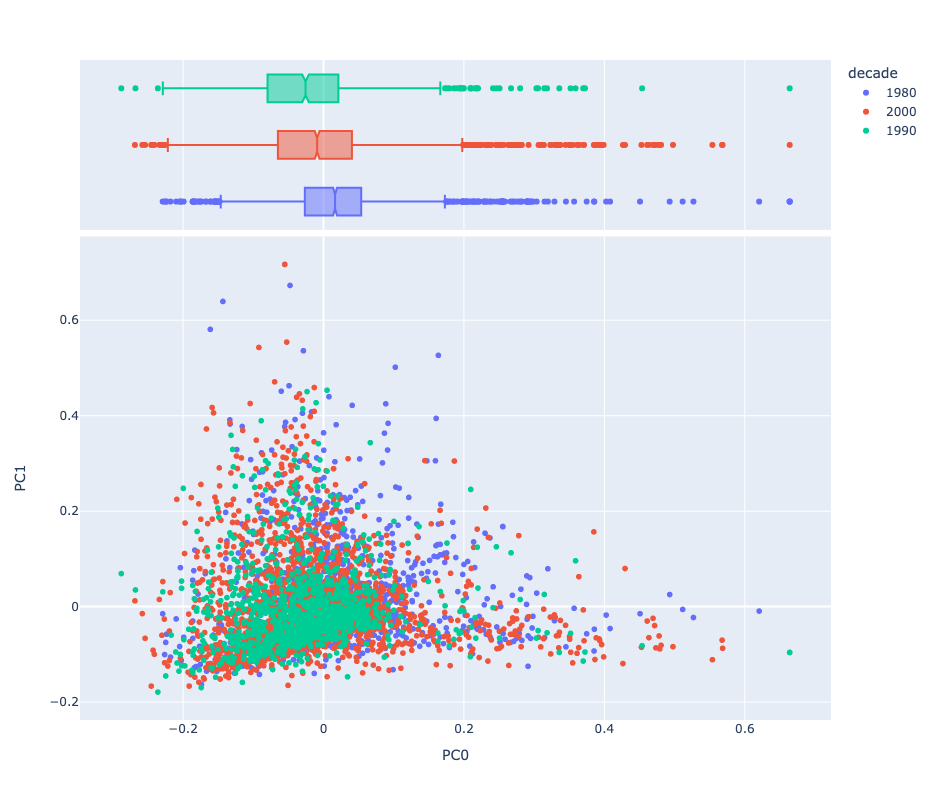

In [59]:
vis_pcs(DCM, 0, 1)

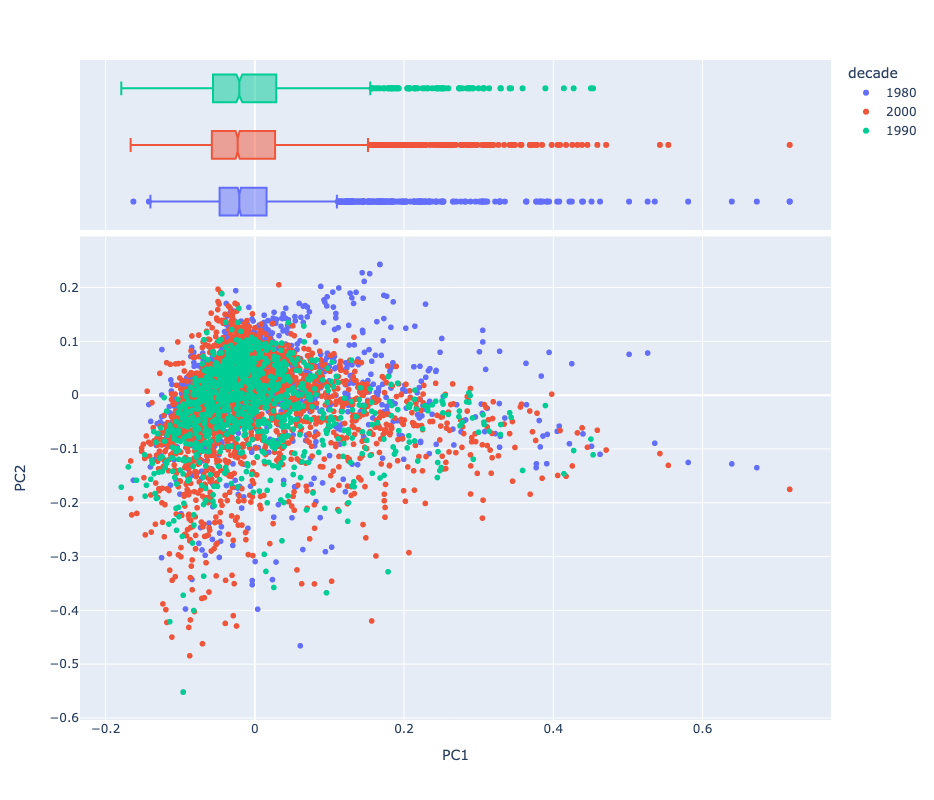

In [60]:
vis_pcs(DCM, 1, 2, label='decade')

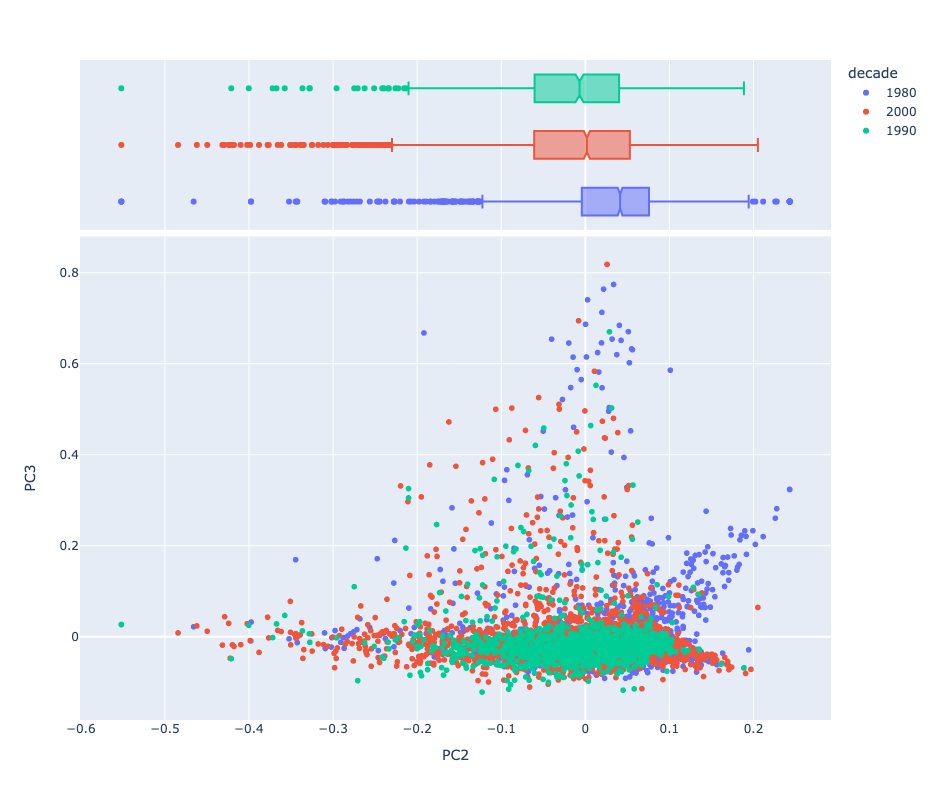

In [61]:
vis_pcs(DCM, 2, 3, label="decade")